### Импорты используемых библиотек:

In [54]:
import os
import pandas as pd
import matplotlib.pyplot as plt

Получаем список имен президентов и содержимое файлов датасета:

In [57]:
path = "../data/addresses/"

In [58]:
presidents = []
contents = []

In [59]:
for _, _, files in os.walk(path):
   for name in files:
      presidents.append(' '.join(name.split()[:2]))
        
      with open(path + name, 'r') as file:
          contents.append(file.read())

In [60]:
presidents

['Abraham Lincoln',
 'Abraham Lincoln',
 'Abraham Lincoln',
 'Abraham Lincoln',
 'Andrew Jackson',
 'Andrew Jackson',
 'Andrew Jackson',
 'Andrew Jackson',
 'Andrew Jackson',
 'Andrew Jackson',
 'Andrew Jackson',
 'Andrew Jackson',
 'Andrew Johnson',
 'Andrew Johnson',
 'Andrew Johnson',
 'Andrew Johnson',
 'Barack Obama',
 'Barack Obama',
 'Barack Obama',
 'Barack Obama',
 'Barack Obama',
 'Barack Obama',
 'Barack Obama',
 'Barack Obama',
 'Benjamin Harrison',
 'Benjamin Harrison',
 'Benjamin Harrison',
 'Benjamin Harrison',
 'Calvin Coolidge',
 'Calvin Coolidge',
 'Calvin Coolidge',
 'Calvin Coolidge',
 'Calvin Coolidge',
 'Calvin Coolidge',
 'Chester A.',
 'Chester A.',
 'Chester A.',
 'Chester A.',
 'Donald J.',
 'Donald J.',
 'Donald J.',
 'Dwight D.',
 'Dwight D.',
 'Dwight D.',
 'Dwight D.',
 'Dwight D.',
 'Dwight D.',
 'Dwight D.',
 'Dwight D.',
 'Franklin D.',
 'Franklin D.',
 'Franklin D.',
 'Franklin D.',
 'Franklin D.',
 'Franklin D.',
 'Franklin D.',
 'Franklin D.',
 'Fran

In [61]:
for text in contents:
    print(text.split()[:10])

['Fellow-Citizens', 'of', 'the', 'Senate', 'and', 'House', 'of', 'Representatives:', 'Since', 'your']
['Fellow-Citizens', 'of', 'the', 'Senate', 'and', 'House', 'of', 'Representatives:', 'In', 'the']
['Fellow-Citizens', 'of', 'the', 'Senate', 'and', 'House', 'of', 'Representatives:', 'Again', 'the']
['Fellow-Citizens', 'of', 'the', 'Senate', 'and', 'House', 'of', 'Representatives:', 'Another', 'year']
['Fellow', 'Citizens', 'of', 'the', 'Senate', 'and', 'of', 'the', 'House', 'of']
['Fellow', 'Citizens', 'of', 'the', 'Senate', 'and', 'of', 'the', 'House', 'of']
['Fellow', 'Citizens', 'of', 'the', 'Senate', 'and', 'of', 'the', 'House', 'of']
['Fellow', 'Citizens', 'of', 'the', 'Senate', 'and', 'of', 'the', 'House', 'of']
['Fellow', 'Citizens', 'of', 'the', 'Senate', 'and', 'of', 'the', 'House', 'of']
['Fellow', 'Citizens', 'of', 'the', 'Senate', 'and', 'of', 'the', 'House', 'of']
['Fellow', 'Citizens', 'of', 'the', 'Senate', 'and', 'of', 'the', 'House', 'of']
['Fellow', 'Citizens', 'of',

In [65]:
texts = pd.DataFrame({"President": presidents, "Text": contents})

In [66]:
texts

,President,Text
0,Abraham Lincoln,\n Fellow-Citizens of the Senate and House of ...
1,Abraham Lincoln,\nFellow-Citizens of the Senate and House of R...
2,Abraham Lincoln,\nFellow-Citizens of the Senate and House of R...
3,Abraham Lincoln,\nFellow-Citizens of the Senate and House of R...
4,Andrew Jackson,\nFellow Citizens of the Senate and of the Hou...
...,...,...
219,Woodrow Wilson,\nGentlemen of the Congress:\nIn fulfilling at...
220,Woodrow Wilson,\nGENTLEMEN OF THE CONGRESS:\nSince I last had...
221,Woodrow Wilson,\nGENTLEMEN OF THE CONGRESS:\nWhen I addressed...
222,Woodrow Wilson,\nGentlemen of the Congress:\nThe session upon...


,Text
President,
Abraham Lincoln,4
Andrew Jackson,8
Andrew Johnson,4
Barack Obama,8
Benjamin Harrison,4
Calvin Coolidge,6
Chester A.,4
Donald J.,3
Dwight D.,8


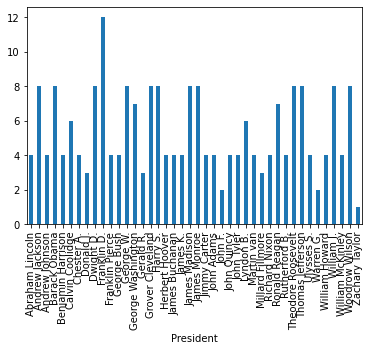

In [81]:
summary = texts.groupby("President").count()
ax = summary.plot.bar(y='Text')
ax.get_legend().remove()
summary